# Transformers Generation Fine-tuning

### Setup and Imports

In this section, we install necessary packages and import required modules.

In [1]:
!pip install -Uqq fastbook
!pip install -Uq transformers

# Importing required modules
import pandas as pd
from fastbook import *
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Setting up fastbook
import fastbook
fastbook.setup_book()

### Custom Tokenizer

Define a custom tokenizer for the Transformers model.

In [2]:
class TransformersTokenizer(Transform):
    """Custom tokenizer for Transformers model."""
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def encodes(self, x):
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

### Load, Explore and Clean the Dataset

Here, we load the dataset containing poems and print out the number of poems in the dataset.

In [3]:
# Define the remove_non_english function
def remove_non_english(text):
    # Regular expression to remove non-English alphabet characters
    english_only = re.sub(r'[^a-zA-Z\s.,;?!\'-]', '', text)
    return english_only

# Define the create_corpus function
def create_corpus(text):
    # Tokenize text into sentences
    sentences = text.split('\n')
    # Remove empty strings
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    # Join sentences into a corpus
    corpus = '\n'.join(sentences)  # Keep newline characters
    return corpus

In [4]:
path = '/kaggle/input/poem-classification-dataset/data.csv'
poems_dataframe = pd.read_csv(path)

print("There are", len(poems_dataframe['poem']),"poems in the dataset")

There are 10064 poems in the dataset


In [5]:
# Apply remove_non_english function to poem column
#poems_dataframe['poem'] = poems_dataframe['poem'].apply(remove_non_english)

# Remove \xa0
#poems_dataframe['poem'] = poems_dataframe['poem'].str.replace('\xa0', '')

# Apply lowercase to the poem column
#poems_dataframe['poem'] = poems_dataframe['poem'].str.lower()

# Print the DataFrame
poems_dataframe

Unnamed: 0  \
0               0   
1               1   
2               2   
3               3   
4               4   
...           ...   
10059       10059   
10060       10060   
10061       10061   
10062       10062   
10063       10063   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          poem  \
0      Sunday we lay hands\non a girl of ten hand on hand on\ncornsilk hair. We sing\nthe secret language sung\nthe day the tin roof of the tower beat\non God’s floorboard\nhe got cramp in heaven.\nLike our crying and our\nfornicating so close to his bed\nwas so many shrill mice in a pretty\npine floor. To heal\nthe girl with the crippled up leg\nGod sends back the song\nhe took and down it comes\ncontrary in one mouth as fire\ngentle on our bodies as rain.\nSoft rain swells the Cumberland\nand all her fields in April nuzzles\nbuttercups the mules won’t touch\nthe crowpoison the wake-robin\nthe b...   
1      O transient voyager of heaven!\n⁠ ⁠ ⁠ O silent sign of winter skies!\nWhat adverse wind thy sail has driven\n⁠ ⁠ ⁠ To dungeons where a prisoner lies?\n\nMethinks the hands that shut the sun\n⁠ ⁠ ⁠ ⁠So sternly from this morning's brow\nMight still their rebel task have done\n⁠⁠ ⁠ ⁠ And checked a thing so frail as thou.\n\nThey would have done it had they known\n⁠ ⁠ ⁠ ⁠The talisman that dwelt in thee,\nFor all the suns that ever shone\n⁠ ⁠ ⁠ ⁠Have never been so kind to me!\n\nFor many a week, and many a day\n⁠⁠ ⁠ ⁠ My heart was weighed with sinking gloom\nWhen morning rose in mourning grey\n...   
2      \n\n\na cento for Sarah Hegazy\n\n\n\n\na cento for Sarah Hegazy\n\na cento for Sarah HegazyIn the hiding\nhour of autophagy\nghosts hang out all day and talk to us.\nAn archival haunting demanding tribute:\n     half a lime for breakfast every day.\nبشرٌ يئنّونَ من الألمِ\nhuman voices keening in pain\nتُشعلُ أجسادَهُمَ النارُ\ntheir bodies, consumed by fire\nlight up the dark\n.فيضيئوا العتمةَ\n\nThey will blame the early morning hours\nفي طَيّ الكُتْمانِ: under the seal of secrecy\nwhere there was no sunrise\n     though\nmoon tells me god is love unconditional. I\n\nten thousand years ...   
3      I am in the middle of “The Fourteen Poems" by Sun Bu-er (“Clear and Calm Free Human”), Taoist and one of the Seven Immortal Sisters who took up the Tao after she turned fifty-one, after her three children grew up, after her husband attained enlightenment—highly approved by The Complete Reality School. She was born in 1124. Commentary by Chen Yingning of the twelfth century. Translated by Thomas Clearly. Copyright 1989. The Chinese is not included.The secret texts may reveal how to really be alive. Those by Sun Bu-er are said to have been handed on by revered Taoist; one of whom was known a...   
4      I lift him out, whole and perfect.\nSaid told me he would be here, chained by Dante\nTo the eighth circle of hell, bettered only by the devil himself.\nThe Paris Review recapped this canto in 2014, saying\nRead along! This week: Mohammed torn asunder.\nAnd so he was, again, “cleft from chin to colon.” In summary\nWe are assured this is a marvelous mangling.\nI cannot abide (t)his pain. I have taken him out,\nWounding the text, the ancient imagining,\nAnd write myself into it so asunder I tear,\nGuts and shit spilling down my legs. Omar,\nFoolish provocateur, no prophet, but sower\nOf schis...   
...                                                                                           

In [6]:
all_poems = L(poems_dataframe['poem'].tolist())

### Tokenization and Data Loading

Tokenize the poems and set up the data loaders.

In [7]:
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2-medium')
splits = [range_of(80), range(100)] # use a 80/20 split

tls = TfmdLists(all_poems, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

### Display Tokenized Text

Display a tokenized sample from the training dataset.

In [8]:
show_at(tls.train, 0)

Sunday we lay hands
on a girl of ten hand on hand on
cornsilk hair. We sing
the secret language sung
the day the tin roof of the tower beat
on God’s floorboard
he got cramp in heaven.
Like our crying and our
fornicating so close to his bed
was so many shrill mice in a pretty
pine floor. To heal
the girl with the crippled up leg
God sends back the song
he took and down it comes
contrary in one mouth as fire
gentle on our bodies as rain.
Soft rain swells the Cumberland
and all her fields in April nuzzles
buttercups the mules won’t touch
the crowpoison the wake-robin
the bluets of the field.
Every song got a beat beneath.
Start with the whippoorwill
early meadow colors creep
into the sky. My sons made this
tobacco sled I prime with the jenny
toss the last of the sandlugs for the rest
to thrive. So hot the wasps hang on the honeysuckle
too spent to buzz a sermon.
I know my song remembers
what my fathers told their strings.
Driskill, KentuckyDriskill, Kentucky


### DataLoaders Setup

Set up the DataLoaders with batch size and sequence length.

In [9]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl, shuffle=True)

Token indices sequence length is longer than the specified maximum sequence length for this model (1456 > 1024). Running this sequence through the model will result in indexing errors


### Display Batch

Display a batch of tokenized text.

In [10]:
dls.show_batch(max_n=3)

### Custom Callback

Define a callback to drop output.

In [11]:
class DropOutput(Callback):
    """Callback to drop output."""
    def after_pred(self):
        self.learn.pred = self.pred[0]

### Model Setup

Set up the GPT-2 language model and the training learner.

In [12]:
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

### Validation

Validate the model.

In [13]:
learn.validate()

(#2) [4.23704195022583,69.20284271240234]

### Learning Rate Finder

Find an optimal learning rate.

SuggestedLRs(valley=0.0003981071640737355)

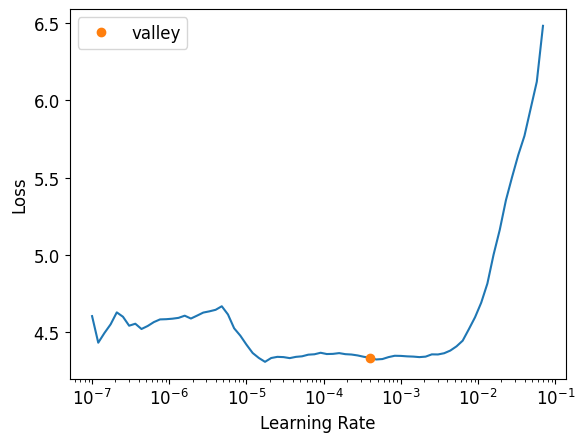

In [14]:
learn.lr_find()

### Model Training

Train the model for 50 epochs.

In [15]:
learn.fit_one_cycle(20, 1e-4)

### Text Generation Function

Define a function to generate text based on a prompt.

In [16]:
def generate_output_from_text(prompt: str) -> str:
    prompt_ids = tokenizer.encode(prompt)
    inp = tensor(prompt_ids)[None].cuda()
    preds = learn.model.generate(inp, max_length=200, num_beams=5, no_repeat_ngram_size=3, early_stopping=True)
    print("===== Output:======\n")
    output = tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True)
    print(output)

### Text Generation Examples

Generate text based on specific prompts.

In [17]:
generate_output_from_text("love is ridiculous, isn't it?")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


===== Output:======

love is ridiculous, isn't it? Don’t you know I have called out to God many times?

Sometimes I think of all the times
I’ve performed salah and made wudu
before holding my mother’s hand in prayer,

or when my father failed to answer
my knock at the door. Grandmother,
take me back to your childhood, where you sang
“Blue Moon” in boarding school, where
you won the talent show.
                                                 Take Me Back to 17
           Where I was crowned Miss Utah in a Miss USA
prize ceremony. I won the Miss Utah
beauty pageant, and my hair
was so voluptuous it covered the
candle of victory. In the back of my mind,
waking up every morning,
making peace with the fact
that I’m Jewish and not Christian,
that my


In [18]:
generate_output_from_text("I don't know what I would do")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


===== Output:======

I don't know what I would do
without you.

For twenty-four hours a day,
I cannot leave
the house. I have to crawl
in the mud. I’m thirsty
too. What do I call
a situation in which water is poured
from a shaft of light into a pan
and a pot of porridge is set on fire

because the Prophet’s beard is unkempt
and the clothes on his back are a dishevelled mess
because you asked for it and I didn’t respond
so I took a piece of chalk and drew a circle around
my body. In that ring, I engraved all the names of my loved ones
who are alive—until the only space left was under my feet.
Outside the circle, names of ones I lost.
A man idling in the middle,
his machine drilling a wound in the solidified water,
ice fishing


In [19]:
generate_output_from_text('Among us, you are the one')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


===== Output:======

Among us, you are the one alone strong enough to face the storm
that will consume your being whole.

—

What once was chanted of Nanna,
Let it now be yours—
That you are as lofty as Heaven and Earth,
Brass knuckles as smooth as Jade,
Your glance is like striking lightning,
Snort when you want to speak,
And your laugh is as sharp as a Scimitar—
You are the all-accomplishing
Thunderbolt. Headlong you charge,
O'er the heads of giants you devastate,
Scattered like a potter's O:
“Lo! the King of glory, Guardian of heaven’s kingdom,
Foremost in the Heavens, Protector of mankind,
The time has come for all men to see
That in you the Lord of heaven dwells
And that you are able to heal all manner of ills,
Like a


In [20]:
generate_output_from_text('Long live the king')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


===== Output:======

Long live the king!
O, happy lot!
Forth unobserved I went,
My house being now at rest.


VI.

As I looked on, a long while
Following the sun,
I beheld in sorrow the Savior’s tree,
Which had been so long and hard on my soul.
I longed to see Him there;
I had long been longing
To behold Him there,
And yet I saw none.
He rested a while, and then rose again,
Hands clasped in remembrance, as if in prayer.
And as He ascended on the high gallows,
He struck the earth with His great
Heavenly voice, saying:
“All is toilsome in the earthly kingdom,
The working of wyrd changes the world under heaven.
Here wealth is fleeting, here friends are fleeting,
But here the King of glory dwells,
With His


In [21]:
generate_output_from_text('I have a dream')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


===== Output:======

I have a dream that I’m almighty God,
the Maker’s might and his mind's thoughts,
eternal Lord. I have put my trust in Him,
held fast to His word, and followed His example.
Now, my beloved hero, time has come
that far and wide they will honor me,
men over the earth and all this glorious creation,
and pray to this sign. On me the Son of God
suffered for a time; and so, glorious now
I rise up under the heavens, and am able to heal
each of those who is in awe of me.
Once I was made into the worst of torments,
most hateful to all people, before I opened
the true way of life for speech-bearers.
 
     “Now I bid you, my dear hero,
that you reveal this vision to men,
tell them in words that it is the
